In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import scipy.stats
import random
from numpy.random import permutation

from IPython.display import HTML, display

from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl import load_workbook
import pandas as pd

In [35]:
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl import load_workbook

wb2 = load_workbook('CAI_Rawdata_27.07.18.xlsx')


In [36]:
def get_batch_data(sheet_name, wb=wb2):
    df = pd.DataFrame(wb[sheet_name].values)
    
    midgrade_to_batch = {}
    
    for index, row in df.iterrows():
        if index == 0:
            continue
        midgrade, tuber_count, batch_weight = row[7:10]
        
        if midgrade in midgrade_to_batch:
            midgrade_to_batch[midgrade].append((tuber_count, batch_weight))
        else:
            midgrade_to_batch[midgrade] = [(tuber_count, batch_weight)]
    return midgrade_to_batch
    
def get_individual_data(sheet_name, wb=wb2):
    df = pd.DataFrame(wb[sheet_name].values)
    
    midgrade_to_weight = {}
    for index, row in df.iterrows():
        if index ==0:
            continue
        midgrade, weight = row[8:10]
        farm = row[6]
        
        if midgrade == None or weight == None:
            break
        if midgrade in midgrade_to_weight:
            midgrade_to_weight[midgrade].append((weight/1000, farm))
        else:
            midgrade_to_weight[midgrade] = [(weight/1000, farm)]
    return midgrade_to_weight

def load_potato_individual_batch(name):
    individual = get_individual_data('{}_Individual'.format(name))
    batch = get_batch_data('{}_5mm'.format(name))
    to_del = []
    for key in batch:   
        if not key in individual:
            to_del.append(key)
    for del_key in to_del:
        del batch[del_key]
    return individual, batch

In [37]:
individual, batch = load_potato_individual_batch(variety)

#ind, batch = load_potato_individual_batch('Soraya')

#batch_data_to_single_count(batch)

In [38]:
def extract_single_count_field(individual, field_name_=None):
    single_count = {}
    for key in individual:
        if not field_name_:
            single_count[key] = individual[key]
        else:
            single_count[key] = [(w,f) for (w,f) in individual[key] if f==field_name_]
    return single_count

def extract_weights(band_to_counts):
    return [item for sublist in 
            [(lambda x: [a[0] for a in x])(d) for d in [band_to_counts[band] for band in band_to_counts]] 
            for item in sublist]

def extract_fields(band_to_counts):
    return [item for sublist in 
            [(lambda x: [a[1] for a in x])(d) for d in [band_to_counts[band] for band in band_to_counts]] 
            for item in sublist]

def batch_data_to_single_count(midgrade_to_batch):
    midgrade_to_batch_new = []
    for bands in midgrade_to_batch:
        if bands == None: 
            break
        else:
            for (counts, weight) in midgrade_to_batch[bands]:
                for i in range(0, counts):
                    midgrade_to_batch_new.append([bands,1,weight/counts]) 
    return pd.DataFrame(sorted(midgrade_to_batch_new), columns=['MidBand', 'counts','Weight'])


def extract_training_data(midgrade_to_batch):
    df=batch_data_to_single_count(midgrade_to_batch)
    training_bands = df['MidBand'].values
    training_weights = df['Weight'].values
    
    return training_bands, training_weights

def extract_testing_bands_weights(individual, field):
    testing_bands=[]
    testing_weight=[]
    for bands in extract_single_count_field(individual, field_name_=field):
        for (weights, field) in extract_single_count_field(individual, field_name_=field)[bands]:
            testing_bands.append(bands)
            testing_weight.append(weights)
    return testing_bands, testing_weight

def get_traning_testing_data_CAI(field,variety):
    
    #midgrade_to_batch = get_batch_data(variety+'_5mm', wb=wb2)
    ind, batch = load_potato_individual_batch(variety)
    
    train_bands, train_weights = extract_training_data(batch)
    
    testing_bands, testing_weight = extract_testing_bands_weights(ind, field)
    
    return train_bands, train_weights,testing_bands, testing_weight


## Field name -- by Vaieties
Maris Piper: 'R21', '582', 'M12', 'Duffy'

Soraya : 'Somerlayton', 'Year 1 trial field', 'Yr 1 variety trial', 'Field', 'Failey 1'

Jelly: 'Franklin', 'Irby Hall Nort', 'Middle Allotement', 'RHP', 'Somerlayton'

Venezia: 'Chanters Hole', 'Hanger Blackdyke', 'Hanger Blackdyke', 'HS2', 'Lovers Pightle', 'TurnPike', 'wortley', 'NSB Trial 1'

Marfona:

Lady Balfour:

Orchestra:



## ## Training and Testing Data,  KNN Classifier,  and Predictions

In [39]:
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import accuracy_score

Optimized_K = {'Orchestra': 3,'Marfona':11, 'LadyBalfour': 30,'Marofona': 35, 'Venezia': 27, 'Soraya': 20,'Jelly': 35, 'MarisPiper': 35} 

def convert_float_int(array):
    for i in range(0,len(array)):
        array[i] = int(array[i]*10000000)
    return array

def convert_int_float(array):
    for i in range(0,len(array)):
        array[i] = array[i]/10000000
    return array

def knn_classifier_CAI(field, variety):
    
    fact_toconvert_int = 10000000
    k_value = Optimized_K[variety]
    
    midsizebands_train_data, Tuberweight_train_data, midsizebands_test_data, Tuberweight_test_data = get_traning_testing_data_CAI(field,variety)
    #converting the array of float into an array of integers, because KNN classifier takes integer or categories as an array
    Tuberweight_test_data = convert_float_int(Tuberweight_test_data)
    Tuberweight_train_data= convert_float_int(Tuberweight_train_data)

    
    #tarining and predicting for Tuber weight
    classifier_weight = KNeighborsClassifier(n_neighbors=k_value)  
    classifier_weight.fit(pd.DataFrame(midsizebands_train_data), Tuberweight_train_data)

    weight_pred = classifier_weight.predict(pd.DataFrame(midsizebands_test_data))

    #training and predicting for Tuber band size --- inVerse problem
    classifier_bandsize = KNeighborsClassifier(n_neighbors=5)  
    classifier_bandsize.fit(pd.DataFrame(Tuberweight_train_data), midsizebands_train_data*10)
    size_pred = classifier_bandsize.predict(pd.DataFrame(Tuberweight_test_data))

    #converting the array of int into an array of floats, because KNN classifier takes integer or categories as an array
    Tuberweight_test_data  = convert_int_float(Tuberweight_test_data)
    weight_pred = convert_int_float(weight_pred)
    
    predicted_df  = pd.DataFrame(np.vstack((midsizebands_test_data, weight_pred, Tuberweight_test_data, size_pred/10)).T,columns=["MidBand","Predicted TuberWeight","True TuberWeight", "Predicted Size"])

    return predicted_df


def give_summary(predicted_dataframe):
    true_counts={}
    pred_counts={}
    true_weight={}
    pred_weight={}
    total_tuber=0
    total_weight=0
    bands_array=[22.5, 27.5, 32.5, 37.5, 42.5, 47.5, 52.5, 57.5, 62.5, 67.5, 17.5]
    
    #------------------------Stats for forcasting --------------------------
    mean_tuber_size = round(np.mean(predicted_dataframe['Predicted Size']),3)
    std_tuber_size = round(np.std(predicted_dataframe['Predicted Size']),3)
    CoV = round((std_tuber_size/mean_tuber_size)*100,3)
    #-----------------------------------------------------------------------

    for bands in sorted(predicted_df['MidBand']):
    #for bands in sorted(predicted_dataframe['Predicted Size']):
    #for bands in sorted(bands_array):
    
        len_true_bands = len(predicted_dataframe[predicted_dataframe['MidBand']==bands]['True TuberWeight'])
        len_predicted_bands = len(predicted_dataframe[predicted_dataframe['Predicted Size']==bands]['Predicted TuberWeight'])
        #print(len_true_bands, len_predicted_bands)

        true_counts[bands] = len(predicted_dataframe[predicted_dataframe['MidBand']==bands])
        pred_counts[bands] = len(predicted_dataframe[predicted_dataframe['Predicted Size']==bands])
        true_weight[bands] = sum(predicted_dataframe[predicted_dataframe['MidBand']== bands]['True TuberWeight'])
        pred_weight[bands] = sum(predicted_dataframe[predicted_dataframe['Predicted Size']== bands]['Predicted TuberWeight'])
   
    row =[]
    for bands in true_counts:
        row.append([bands,  true_counts[bands] ,round(true_weight[bands],4), pred_counts[bands] ,round(pred_weight[bands],4)])
        data_frame = pd.DataFrame(sorted(row), columns=["MidBand", "True Counts", "True Weight", "Predicted Counts", "Predicted Weight"])  
    
    #------------------------OutPut----------------------------------------------------------------
    total_tubers = round(sum(data_frame['True Counts'].values),3)
    total_weight = round(sum(data_frame['True Weight'].values),3)
    K = round(mean_tuber_size /((total_weight/total_tubers)**(1/3)),2)
    #mean_tuber_size = sum(data_frame['MidBand'].values)/len(data_frame['MidBand'].values)
    #frequency = data_frame['Predicted Weight'].values/(total_weight)*100

    stat_summary = pd.DataFrame([[total_tubers, total_weight, mean_tuber_size,std_tuber_size, CoV, K]],
                               columns = ['Total Tubers', 'Total Weight', 'Mean Size', 'Std', 'CoV', 'K'])
    print(stat_summary)
    #------------------------------------------------------------------------------------------------
    
    return data_frame, stat_summary




## Soraya

Variety: Soraya
Yr 1 variety trial Field
   Total Tubers  Total Weight  Mean Size     Std     CoV       K
0           165         15.48     46.955  10.031  21.363  103.34
    MidBand  True Counts  True Weight  Predicted Counts  Predicted Weight
0      17.5           11       0.0408                 0            0.0000
1      22.5            3       0.0239                 7            0.0350
2      27.5            2       0.0289                10            0.0775
3      32.5            3       0.0760                 5            0.0991
4      37.5           13       0.4721                11            0.2399
5      42.5           16       0.9534                19            0.6116
6      47.5           37       3.1252                44            2.6424
7      52.5           46       5.2695                35            2.3713
8      57.5           22       3.2834                25            2.8855
9      62.5           11       1.9823                 8            1.2474
10     67.5    

/home/sma74/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


   Total Tubers  Total Weight  Mean Size    Std     CoV       K
0           193        16.329     45.298  9.641  21.284  103.18
    MidBand  True Counts  True Weight  Predicted Counts  Predicted Weight
0      17.5            2       0.0098                 0            0.0000
1      22.5            4       0.0257                 6            0.0400
2      27.5            7       0.0925                11            0.1273
3      32.5            4       0.0743                 7            0.1266
4      37.5           22       0.7489                26            0.6432
5      42.5           40       2.2147                44            1.5979
6      47.5           39       3.0565                35            2.0869
7      52.5           30       3.2879                33            2.8293
8      57.5           36       5.0337                23            2.7653
9      62.5            8       1.5361                 5            0.7179
10     67.5            1       0.2484                 3   

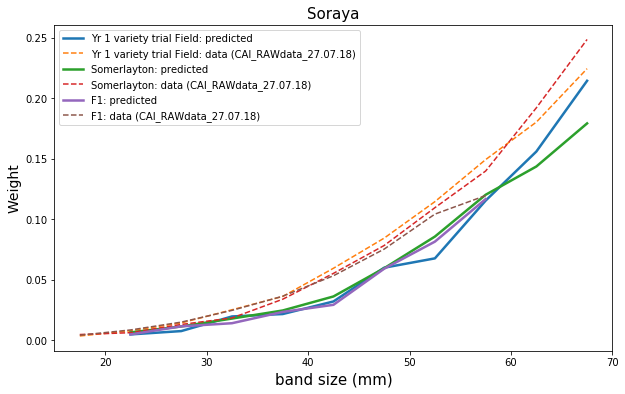

In [60]:
variety = 'Soraya'

individual, batch = load_potato_individual_batch(variety)

fig1 = plt.figure(figsize=(10,6))
print('Variety:', variety )
for field in set(extract_fields(extract_single_count_field(individual))):
        print(field)
        predicted_df = knn_classifier_CAI(field,variety)
        summary, statistics_summary = give_summary(predicted_df)
        plot_tuberweight_CAI(summary, variety, field)
        print(summary)
        #print(statistics_summary.to_latex())
        #print(summary.to_latex())
        file = open('Latex/summary_'+variety.replace(" ", "")+'_'+field.replace(" ", "")+'_CAI.tex','w') 
        file.write(statistics_summary.to_latex()+'\n'+summary.to_latex()) 
        file.close() 

plt.xlabel('band size (mm)', fontsize=15)
plt.ylabel('Weight', fontsize=14)
plt.legend()
plt.show() 
fig1.savefig('figures/Tuberweight_plots_'+variety+'_CAI.pdf', bbox_inches='tight')


## Jelly

Variety: Jelly
Irby Hall Nort
   Total Tubers  Total Weight  Mean Size    Std     CoV      K
0           311        15.795     38.143  8.538  22.384  103.0
   MidBand  True Counts  True Weight  Predicted Counts  Predicted Weight
0     17.5            9       0.0421                 7            0.0257
1     22.5           17       0.1548                19            0.0971
2     27.5           23       0.3733                29            0.2800
3     32.5           46       1.1360                43            0.5009
4     37.5           57       2.1516                74            1.6611
5     42.5           79       4.5079                77            3.1022
6     47.5           51       4.1205                44            2.7489
7     52.5           23       2.3676                13            1.0746
8     57.5            5       0.7077                 4            0.4497
9     62.5            1       0.2340                 0            0.0000
RHP


/home/sma74/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


   Total Tubers  Total Weight  Mean Size    Std     CoV       K
0           236        12.525     38.453  9.558  24.856  102.32
   MidBand  True Counts  True Weight  Predicted Counts  Predicted Weight
0     17.5           13       0.0628                13            0.0503
1     22.5           10       0.0884                12            0.0730
2     27.5           17       0.2481                21            0.2006
3     32.5           31       0.7998                27            0.3498
4     37.5           44       1.7498                49            1.0311
5     42.5           60       3.5652                52            1.8156
6     47.5           39       3.3675                41            2.3344
7     52.5           21       2.4366                18            1.3467
8     57.5            1       0.2066                 1            0.0811
Middle Allotment
   Total Tubers  Total Weight  Mean Size    Std     CoV      K
0           224         8.587     34.866  8.529  24.462  103.4

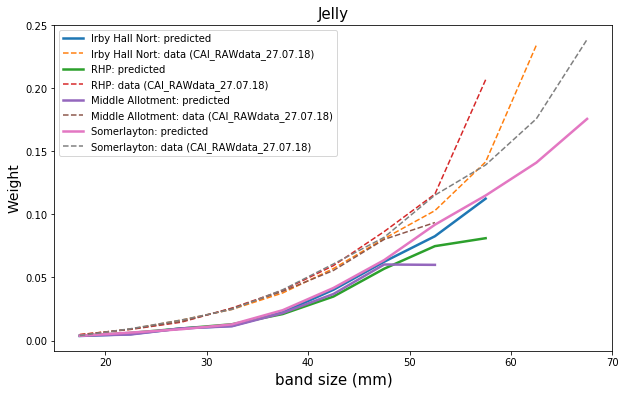

In [58]:
variety = 'Jelly'

individual, batch = load_potato_individual_batch(variety)

fig1 = plt.figure(figsize=(10,6))
print('Variety:', variety )
for field in set(extract_fields(extract_single_count_field(individual))):
        print(field)
        predicted_df = knn_classifier_CAI(field,variety)
        summary, statistics_summary = give_summary(predicted_df)
        plot_tuberweight_CAI(summary, variety, field)
        print(summary)
        #print(summary.to_latex())
        file = open('Latex/summary_'+variety.replace(" ", "")+'_'+field.replace(" ", "")+'_CAI.tex','w') 
        file.write(statistics_summary.to_latex()+'\n'+summary.to_latex()) 
        file.close() 

plt.xlabel('band size (mm)', fontsize=15)
plt.ylabel('Weight', fontsize=14)
plt.legend()
plt.show() 
fig1.savefig('figures/Tuberweight_plots_'+variety+'_CAI.pdf', bbox_inches='tight')



Variety: MarisPiper
R21
   Total Tubers  Total Weight  Mean Size    Std     CoV       K
0           274         7.606     31.679  6.846  21.611  104.63
   MidBand  True Counts  True Weight  Predicted Counts  Predicted Weight
0     17.5           12       0.0587                 6            0.0180
1     22.5           31       0.2988                45            0.3549
2     27.5           66       1.0794                63            0.6713
3     32.5           47       1.2737                77            1.7100
4     37.5           83       2.8706                46            1.1859
5     42.5           35       2.0248                31            1.0914
M12
   Total Tubers  Total Weight  Mean Size    Std     CoV       K
0           285        20.717     42.711  11.04  25.848  102.34
   MidBand  True Counts  True Weight  Predicted Counts  Predicted Weight
0     17.5            7       0.0301                 5            0.0189
1     22.5           16       0.1292                24     

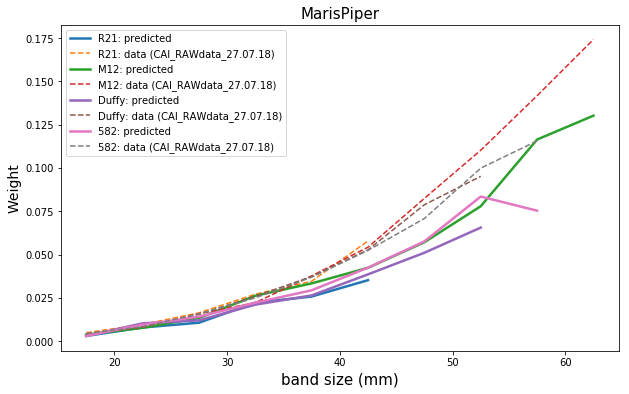

In [57]:
variety = 'MarisPiper'

individual, batch = load_potato_individual_batch(variety)

fig1 = plt.figure(figsize=(10,6))
print('Variety:', variety )
for field in set(extract_fields(extract_single_count_field(individual))):
        print(field)
        predicted_df = knn_classifier_CAI(field,variety)
        summary, statistics_summary = give_summary(predicted_df)
        plot_tuberweight_CAI(summary, variety, str(field))
        print(summary)
        #print(summary.to_latex())
        file = open('Latex/summary_'+variety.replace(" ", "")+'_'+str(field).replace(" ", "")+'_CAI.tex','w') 
        file.write(statistics_summary.to_latex()+'\n'+summary.to_latex()) 
        file.close() 

plt.xlabel('band size (mm)', fontsize=15)
plt.ylabel('Weight', fontsize=14)
plt.legend()
plt.show() 
fig1.savefig('figures/Tuberweight_plots_'+variety+'_CAI.pdf', bbox_inches='tight')




In [56]:
def plot_tuberweight_CAI(summary, variety, field):
    df = pd.DataFrame(summary)
    bandsize = df['MidBand'].loc[:].values
    pred_tuberweight = df['Predicted Weight'].loc[:].values/df['Predicted Counts'].loc[:].values
    true_tuberweight = df['True Weight'].loc[:].values/df['True Counts'].loc[:].values

    plt.plot(bandsize, pred_tuberweight, lw=2.5, label=field+': predicted')
    plt.plot(bandsize, true_tuberweight, ls='dashed', label=field+': data (CAI_RAWdata_27.07.18)')
    plt.title(variety, fontsize=15)
   

# Error --- Maris Piper

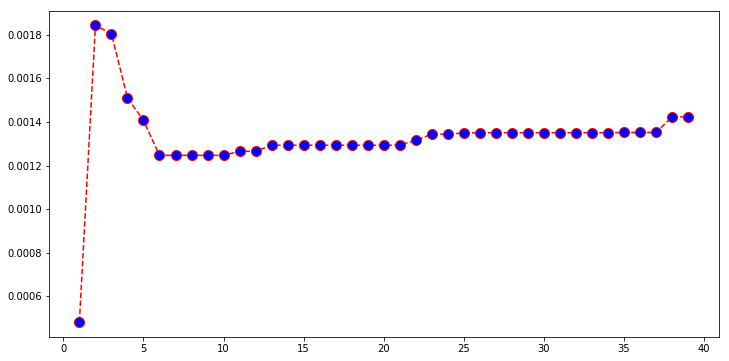

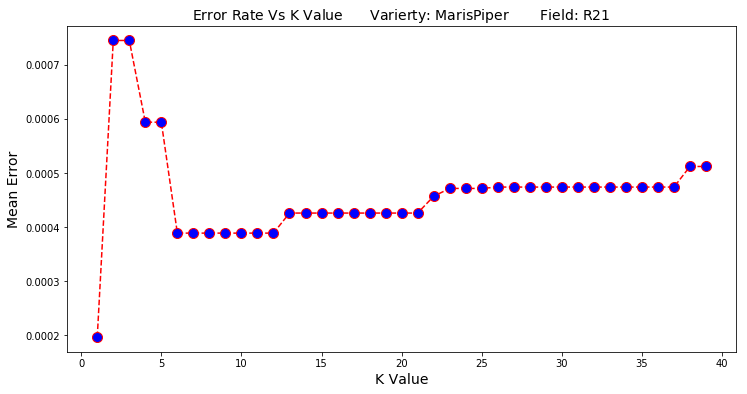

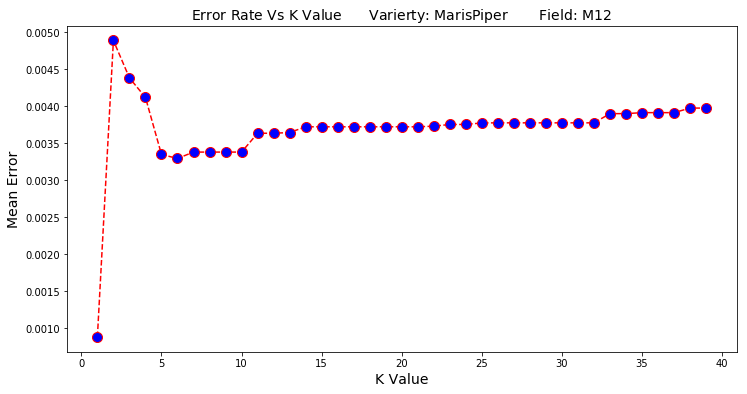

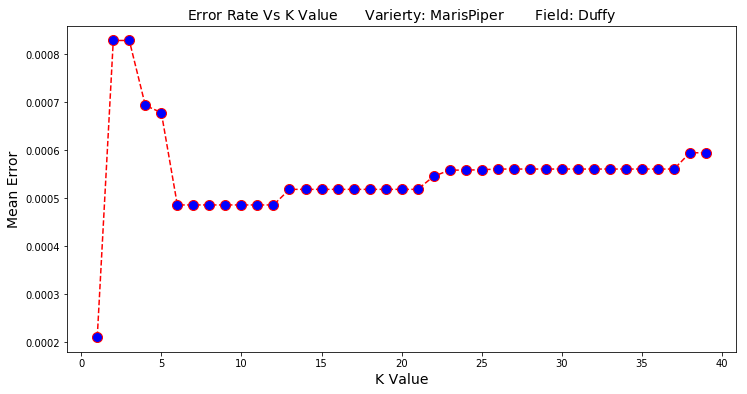

TypeError: must be str, not int

In [53]:
def error_plot_CAI(field, variety,individual):

    error=[]
    midsizebands_train_data, Tuberweight_train_data, midsizebands_test_data, Tuberweight_test_data = get_traning_testing_data_CAI(field,variety)
    fact_toconvert_int = 10000000
    #converting the array of float into an array of integers, because KNN classifier takes integer or categories as an array
    Tuberweight_test_data = convert_float_int(Tuberweight_test_data)
    Tuberweight_train_data= convert_float_int(Tuberweight_train_data)
    
    for i in range(1,40):
        knn = KNeighborsClassifier(n_neighbors=i)  
  
        #tarining and predicting for Tuber weight
        KNN = KNeighborsClassifier(n_neighbors=i)  
        KNN.fit(pd.DataFrame(midsizebands_train_data), Tuberweight_train_data)
 
        weight_pred_i = KNN.predict(pd.DataFrame(midsizebands_test_data))
    
        #converting the array of int into an array of floats, because KNN classifier takes integer or categories as an array
        Tuberweight_test_data  = convert_int_float(Tuberweight_test_data)
        weight_pred_i = convert_int_float(weight_pred_i)
    
        error.append(np.sum((weight_pred_i - Tuberweight_test_data)**2/len(Tuberweight_test_data)))

    
    
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=(12,6))
    plt.plot(range(1,40), error, color='red', linestyle='dashed', marker='o',
            markerfacecolor='blue', markersize=10)
    plt.title('Error Rate Vs k Value (used in KNN)'+ '$\qquad $Varierty: '+variety+'$\qquad$ Field: '+field, fontsize=14)
    plt.xlabel('K Value', fontsize=14)
    plt.ylabel('Mean Error', fontsize=14)
    plt.show()

    fig.savefig('figures/error_k_value_'+variety+'_'+field+'_+CAI.pdf', bbox_inches='tight')

    
variety = 'MarisPiper'

individual, batch = load_potato_individual_batch(variety)
  
for field in set(extract_fields(extract_single_count_field(individual))):
    error_plot_CAI(field, variety, individual)   

## Error -- Soraya

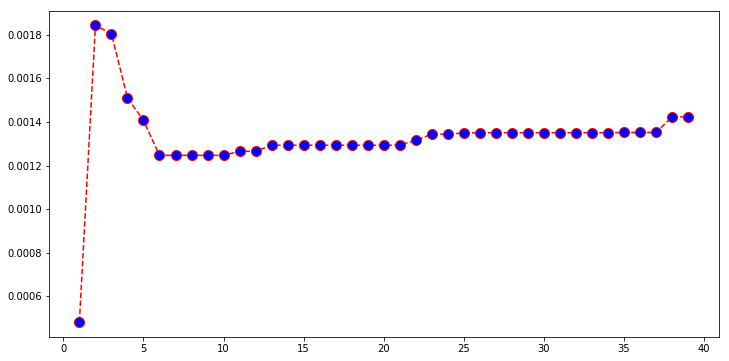

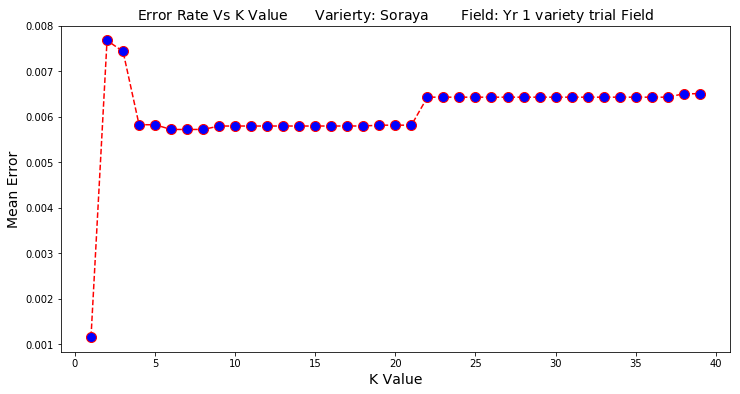

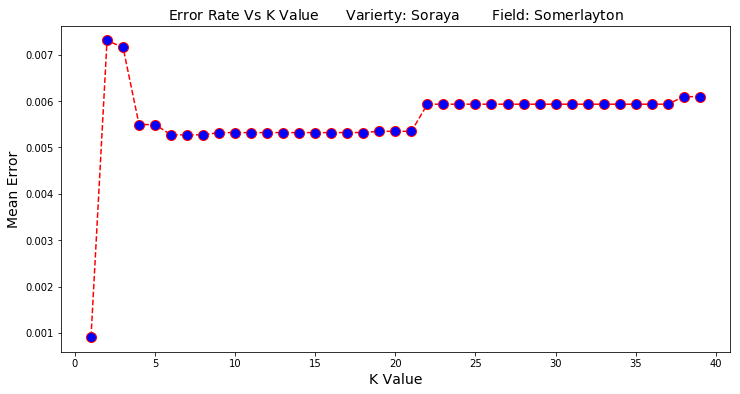

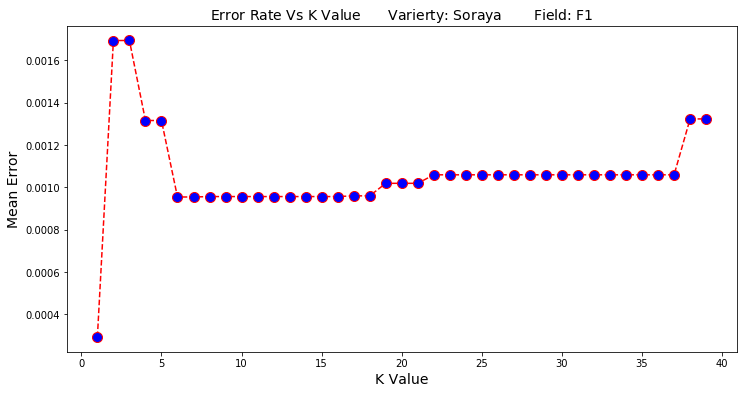

In [54]:
variety = 'Soraya'

individual, batch = load_potato_individual_batch(variety)
  
for field in set(extract_fields(extract_single_count_field(individual))):
    error_plot_CAI(field, variety, individual)   

## Error -- Jelly

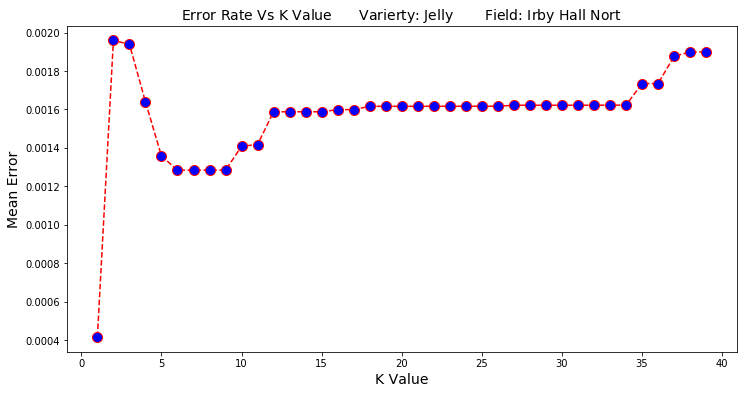

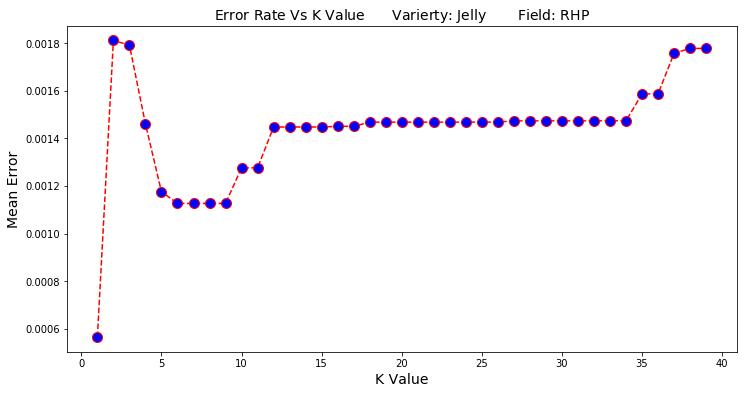

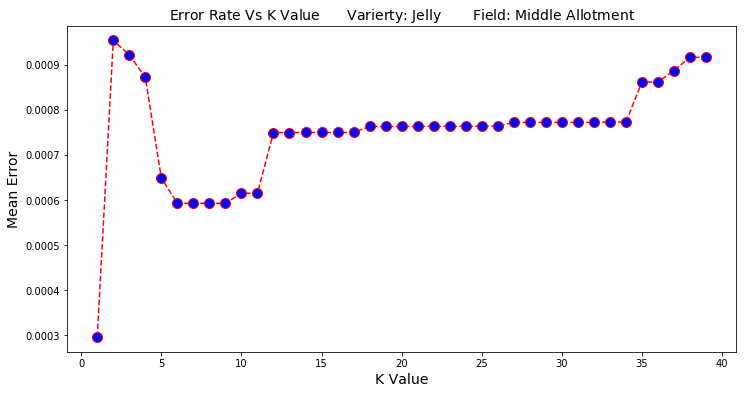

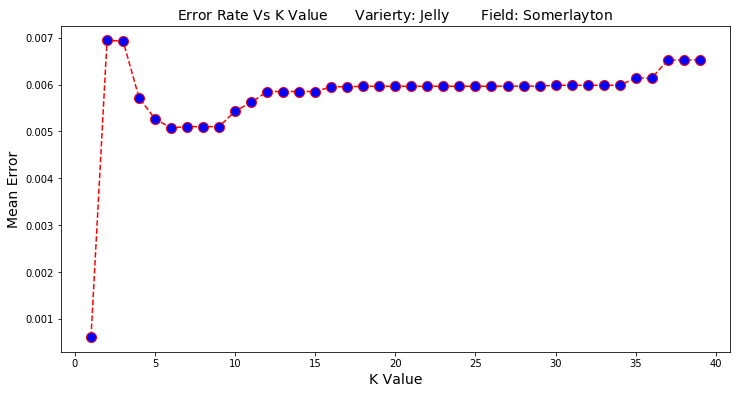

In [55]:
variety = 'Jelly'

individual, batch = load_potato_individual_batch(variety)
  
for field in set(extract_fields(extract_single_count_field(individual))):
    error_plot_CAI(field, variety, individual)   